## Shadow Mask Label Generation by Thresholding Band Values and Spectral Indices

### Explored Features and Indices:
- NIR Band (B4)
- NDVI (Normalized Difference Vegetation Index) = (NIR - Red) / (NIR + Red + 1e-6)
- BI (Brightness Index) = sqrt((Green^2 + Red^2 + NIR^2) / 3)
- PCI (Pseudo Cloud Index) = (Green + Red) / (NIR + 1e-6)
- VNDI (Vegetation-NIR Difference Index) = (Green + Red - NIR) / ((Green + Red) + NIR + 1e-6)
- NRGR (Normalized Red-Green Ratio) = NIR / (Green + Red + 1e-6)
##### Different combinations of spectral indices and corresponding thresholds were applied across different images.

In [10]:
import numpy as np
import rasterio
from rasterio.windows import Window
from scipy.ndimage import binary_closing, binary_opening, binary_dilation, label
from skimage.transform import resize
import matplotlib.pyplot as plt

In [11]:
# Radiance conversion parameters
Lmax = {'B2': 52.0, 'B3': 47.0, 'B4': 31.5}
DN_max = 1023.0

def load_band_sources(b2_path, b3_path, b4_path):
    return rasterio.open(b2_path), rasterio.open(b3_path), rasterio.open(b4_path)

def dn_to_radiance(band_dn, band_name):
    return (band_dn / DN_max) * Lmax[band_name]

def calculate_indices(B2, B3, B4):
    NDVI = (B4 - B3) / (B4 + B3 + 1e-6)
    BI = np.sqrt((B2**2 + B3**2 + B4**2) / 3)
    PCI = (B2 + B3) / (B4 + 1e-6)
    VNDI = (B2 + B3 - B4) / ((B2 + B3) + B4 + 1e-10)
    NRGR = B4 / (B2 + B3 + 1e-6)
    NIR = B4
    return {
        "NDVI": NDVI, "BI": BI, "PCI": PCI,
        "VNDI": VNDI, "NRGR": NRGR, "NIR": NIR
    }

def create_shadow_mask(indices, thresholds):
    mask = np.ones_like(next(iter(indices.values())), dtype=np.uint8)
    for index_name, threshold in thresholds.items():
        if index_name in ["VNDI", "BI", "NIR", "PCI"]:
            mask &= (indices[index_name] < threshold)
        else:
            mask &= (indices[index_name] > threshold)
    return mask


In [12]:
def display_shadow_mask(path, title="Shadow Mask", downscale=8):
    with rasterio.open(path) as src:
        # Downsample while reading
        mask = src.read(
            out_shape=(1, src.height // downscale, src.width // downscale)
        )[0]

    plt.figure(figsize=(10, 10))
    img = plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
    plt.title(title)
    plt.axis('off')
    plt.colorbar(img, fraction=0.046, pad=0.04, label='Shadow Mask')
    plt.show()

In [15]:
def process_image(b2_path, b3_path, b4_path, output_path,tile_size, thresholds):

    B2_src, B3_src, B4_src = load_band_sources(b2_path, b3_path, b4_path)
    profile = B2_src.profile
    profile.update(dtype=rasterio.uint8, count=1)

    height, width = B2_src.height, B2_src.width

    with rasterio.open(output_path, 'w', **profile) as dst:
        for i in range(0, height, tile_size):
            for j in range(0, width, tile_size):
                win_h = min(tile_size, height - i)
                win_w = min(tile_size, width - j)
                window = Window(j, i, win_w, win_h)

                B2 = dn_to_radiance(B2_src.read(1, window=window).astype(np.float32), 'B2')
                B3 = dn_to_radiance(B3_src.read(1, window=window).astype(np.float32), 'B3')
                B4 = dn_to_radiance(B4_src.read(1, window=window).astype(np.float32), 'B4')

                indices = calculate_indices(B2, B3, B4)
                shadow_mask = create_shadow_mask(indices, thresholds)
                dst.write(shadow_mask, 1, window=window)

    B2_src.close(), B3_src.close(), B4_src.close()
    print(f"Shadow mask saved to {output_path}")

def postprocess_mask(input_path, output_path):
    with rasterio.open(input_path) as src:
        mask = (src.read(1) > 0).astype(np.uint8)
        profile = src.profile

    se_small = np.ones((3, 3), dtype=np.uint8)
    se_large = np.ones((10, 10), dtype=np.uint8)

    mask = binary_closing(mask, structure=se_small, iterations=1)
    mask = binary_opening(mask, structure=se_small, iterations=1)
    mask = binary_dilation(mask, structure=se_small, iterations=1)
    mask = binary_closing(~mask, structure=se_large, iterations=1)
    mask = ~mask
    mask = (label(mask)[0] > 0).astype(np.uint8)

    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(mask, 1)

    print(f"Post-processed shadow mask saved to {output_path}")

In [16]:
# Example

# File paths
b2 = r"D:\NRSC\BH_RAF10SEP2024040267010800054SSANSTUC00GTDC\BAND2.tif"
b3 = r"D:\NRSC\BH_RAF10SEP2024040267010800054SSANSTUC00GTDC\BAND3.tif"
b4 = r"D:\NRSC\BH_RAF10SEP2024040267010800054SSANSTUC00GTDC\BAND4.tif"

# Thresholds for shadow masking
thresholds = {
    "NDVI": 0.17,
    "NRGR": 0.4,
    "BI": 7.5,
    "NIR": 6.5
}

raw_mask_path = "shadow_mask.tif"
final_mask_path = "final_shadow_mask.tif"
tile_size = 1024

process_image(b2, b3, b4, raw_mask_path, tile_size, thresholds)
postprocess_mask(raw_mask_path, final_mask_path)

Shadow mask saved to shadow_mask.tif
Post-processed shadow mask saved to final_shadow_mask.tif


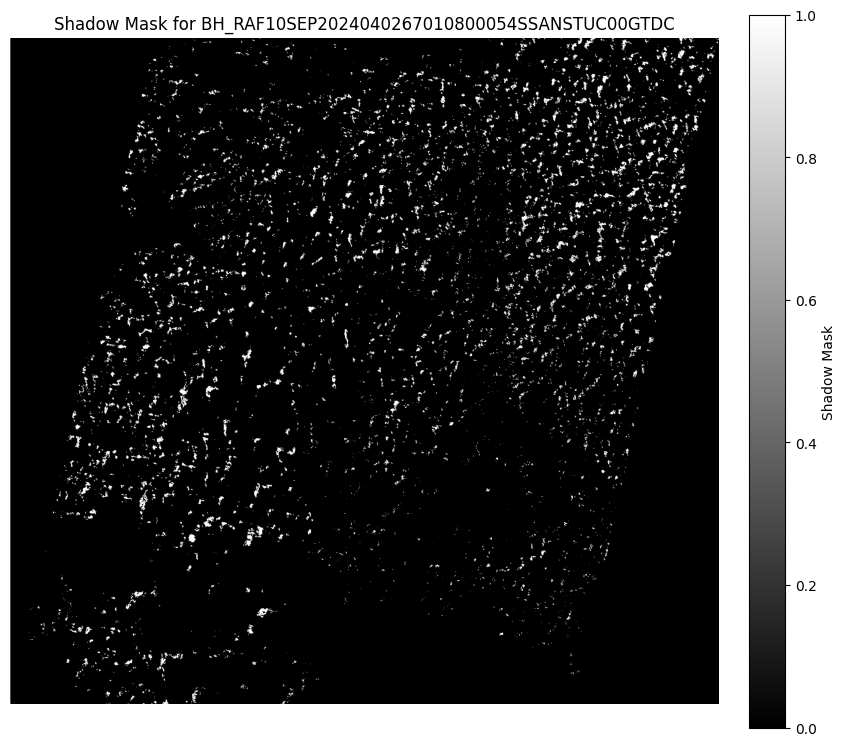

In [17]:
display_shadow_mask("final_shadow_mask.tif", title="Shadow Mask for BH_RAF10SEP2024040267010800054SSANSTUC00GTDC")
